# Evaluation of Relationship Annotation Accuracy Based on a QC'd Sample

This notebook covers the evaluation of user annotations in comparison of the randomly sampled set of completed tasks that have been manually annotated.  

## Import modules and load data

In [1]:
import pandas
import numpy
import m2c_rel_basic
import relationship_dictionaries
import random
import matplotlib
from matplotlib import pyplot as mplot
from pandas import read_csv

Import the relationship annotations data for only completed concept pairs

In [2]:
savepath = 'data/'
exppath = 'results/'
all_completed_anns = read_csv(exppath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)

Import the Quality Curated Sample Annotations

In [3]:
esample_df = m2c_rel_basic.get_QC_data(savepath)

Import the dictionaries for translating hashed responses

In [4]:
rel_hash_dict,redundant_response_dict,abbreviated_rels_dict,abbreviated_rels_dict_4_hash,concept_broken_dict,concept_not_broken_dict = relationship_dictionaries.load_RE_dictionaries()

## Analyze the user annotations relative to the quality curated annotations

pull the annotations marked 'broken' during QC'ing into a set

In [5]:
expert_broken = esample_df.loc[esample_df['conclusion']=='concept_broken']

pull the cpmids (concept pair pmid hashed identifiers) that were QC'd into a set

In [6]:
expert_cpmids = set(esample_df['cpmid'].tolist())

Get the cpmids from the set of annotations that were QC'd and use the cpmids from the QC'd set to pull all user annotations for the same cpmids

In [7]:
test_set_cpmids = set(expert_cpmids)
total_ref_set = all_completed_anns.loc[all_completed_anns['cpmid'].isin(test_set_cpmids)].copy()

Abbreviate the user responses for ease of viewing

In [8]:
total_ref_set['evtype'].replace(abbreviated_rels_dict_4_hash, inplace=True)

Remove distinction between C1 broken and C2 broken since it's technically possible for both to be true AND because it's not important to distinguish it in this analysis

In [9]:
total_ref_set['evtype'].replace(concept_broken_dict, inplace=True)
esample_df['conclusion'].replace(concept_broken_dict, inplace=True)
print(total_ref_set.head(2))

   kind             ann_date  user_id         evtype reltype      pmid  \
8    re  2016-05-24 06:54:49      364  g_unrelated_d     g_d  11353896   
14   re  2016-05-24 07:23:43      364   g_mutation_d     g_d  16970037   

        concept_created      concept_updated refid1   refid2    concept_pair  \
8   2015-05-21 17:54:48  2015-05-21 17:54:48   4158  D004931  4158_x_D004931   
14  2015-05-21 17:54:44  2015-05-21 17:54:44   8086  D009461  8086_x_D009461   

   refid1_type refid2_type  user_count  relation_count  test_completions  \
8            g           d        29.0            14.0               1.0   
14           g           d        27.0            19.0               3.0   

    true_responses  response_ratio                    cpmid  
8             28.0        0.500000  11353896_4158_x_D004931  
14            24.0        0.791667  16970037_8086_x_D009461  


### Randomly subsample the user annotations to determine how worker number (n) relates to agreement with the quality-checked results.

Sample the responses and put the results into a dataframe, 10 iterations per n per cpmid. 
Note that this is the slowest part of the notebook

In [ ]:

n=1
majority_response=[]

i=0
while i<10:
    n=1
    while n<16:
        for each_cpmid in test_set_cpmids:
            result_dict = {}
            result_dict['iteration'] = i
            result_dict['cpmid'] = each_cpmid
            result_dict['n'] = n
            tmp_df = total_ref_set.loc[total_ref_set['cpmid']==each_cpmid]
            user_set = set(tmp_df['user_id'].tolist())
            if n<=len(user_set):
                user_sample = random.sample(user_set, n)
                ref_sample = tmp_df.loc[tmp_df['user_id'].isin(user_sample)]
                if n == 1:
                    result_dict['response'] = ref_sample.iloc[0]['evtype']
                    result_dict['majority?'] = 'yes'
                    result_dict['tie?'] = 'no'
                    result_dict['result_selection'] = 'single_vote'
                else:
                    ## Groupby response and get biggest and next biggest value    
                    ref_sample_size = ref_sample.groupby(['cpmid','evtype']).size().reset_index(name='counts')
                    ref_sample_size.sort_values('counts', ascending=False, inplace=True)
                    first_most = ref_sample_size.iloc[0]['counts']
                    try:
                        sec_most = ref_sample_size.iloc[1]['counts'] ##if this works, results are not unanimous
                        if first_most > sec_most: ## If there is a majority
                            result_dict['majority?'] = 'simple_majority'
                            result_dict['result_selection'] = 'majority'
                            result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                            result_dict['tie?'] = 'no'
                        else: ## else it's a tie
                            result_dict['majority?'] = 'no_majority'
                            result_dict['result_selection'] = 'random'
                            if len(ref_sample_size)==2: ## check if full tie
                                rand_option = random.randint(0, 1)
                                result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                result_dict['tie?'] = 'two_way'
                            elif (len(ref_sample_size) > 2) & (sec_most > ref_sample_size.iloc[3]['counts']): #check if majority tied
                                rand_option = random.randint(0, 1)
                                result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                result_dict['tie?'] = 'top_two_way'
                            elif (len(ref_sample_size) > 2) & (sec_most == ref_sample_size.iloc[3]['counts']): #check for 3-way tie                      
                                rand_option = random.randint(0, 2)
                                result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                result_dict['tie?'] = '3_way'
                            else:    
                                rand_option = random.randint(0, len(ref_sample_size))
                                result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                result_dict['tie?'] = 'other'
                    except: ## Scenario: results are unanimous
                        result_dict['majority?'] = 'unanimous'
                        result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                        result_dict['tie?'] = 'no'
                        result_dict['result_selection'] = 'majority'
            else:
                result_dict['majority?'] = 'n/a'
                result_dict['response'] = 'not_enough'
                result_dict['tie?'] = 'n/a'
                result_dict['result_selection'] = 'n/a' 
            ## check how well user response matched expert response
            tmp_edf = esample_df.loc[esample_df['cpmid']==each_cpmid]           
            test_response = result_dict.get('response')
            expert_response = tmp_edf['conclusion'].iloc[0]
            if test_response=='not_enough':
                result_dict['expert_match?'] = 'n/a'
            elif test_response == expert_response:
                result_dict['expert_match?'] = 'yes'
            else:
                result_dict['expert_match?'] = 'no'
            majority_response.append(result_dict) 
        n = n+1
    i=i+1
   

majority_df = pandas.DataFrame(majority_response)

print(majority_df.head(5))

In [ ]:
#majority_df.to_csv(exppath+'raw_random_accuracy_results.txt',sep='\t',header=True)

In [10]:
#majority_df = read_csv(exppath+'raw_random_accuracy_results.txt',delimiter='\t',header=0)
#majority_df.drop('Unnamed: 0',axis=1, inplace=True)

### Aggregate the resulting data, grouping by iteration and threshold

Count number of expert_match (true positive) vs total number of responses (true positive plus incorrect response) 
This gives total number of answers that matched vs didn't match the QC'd result for the whole QC cpmid set at every level of n, for each repetition and iteration

In [11]:
response_matrix = majority_df.groupby(['iteration','n','expert_match?']).size().reset_index(name='counts')

remove the n/a responses (this is usually when n exceeds sample due to removal of tester account data)

In [12]:
response_matrix_less_missing = response_matrix.loc[response_matrix['expert_match?']!='n/a']
total_captured = response_matrix_less_missing.groupby(['iteration','n'])['counts'].sum().reset_index(name='totals')


Merge tables to be able to do calculations and obtain total attempts, then calculate accuracy (True Positive/Total) and inaccuracy (Incorrect Response/Total)

In [13]:
tmpresults_df = response_matrix.merge(total_captured,on=(['iteration','n']))
tmpresults_df['ratios'] = tmpresults_df['counts']/tmpresults_df['totals']
#print(tmpresults_df)

Since accuracy only counts true positives and total attempts, keep only the true positive data and Calculate the mean, max, median, and sem of the accuracy data frame by aggregating over the 10 iterations

In [14]:
accuracy_df = tmpresults_df.loc[tmpresults_df['expert_match?']=='yes']

mean_accuracy = accuracy_df.groupby(['n']).ratios.mean().reset_index(name='mean_accuracy')
max_accuracy = accuracy_df.groupby(['n']).ratios.max().reset_index(name='max_accuracy')
median_accuracy = accuracy_df.groupby(['n']).ratios.median().reset_index(name='median_accuracy')
median_q25 = accuracy_df.groupby(['n']).ratios.quantile(0.25).reset_index(name='med_q25')
median_q75 = accuracy_df.groupby(['n']).ratios.quantile(0.75).reset_index(name='med_q75')
mean_error = accuracy_df.groupby(['n']).ratios.sem().reset_index(name='std_error')
mean_dev = accuracy_df.groupby(['n']).ratios.std().reset_index(name='std_dev')
    
stats_result = mean_accuracy.merge(max_accuracy.merge(median_accuracy.merge(mean_error.merge(mean_dev.merge(median_q25.merge(median_q75, on=(['n']), how='left'), on=(['n']), how='left'), on=(['n']), how='left'), on=(['n']), how='left'), on=(['n']), how='left'), on=(['n']), how='left')
print(stats_result.head(n=2))

   n  mean_accuracy  max_accuracy  median_accuracy  std_error   std_dev  \
0  1       0.653448      0.689655         0.659483   0.009770  0.030896   
1  2       0.641379      0.681034         0.642241   0.008348  0.026399   

    med_q25   med_q75  
0  0.633621  0.672414  
1  0.637931  0.659483  


### Visualize the results

plot of mean and standard deviation


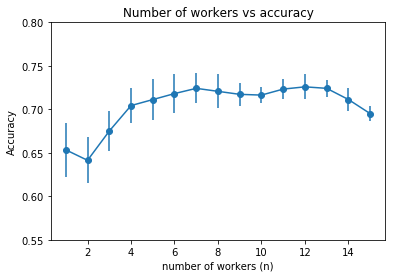

In [15]:
print("plot of mean and standard deviation")
plot_it = stats_result[['mean_accuracy','n','std_dev']].copy()
mplot.figure()
mplot.xlabel("number of workers (n)")
mplot.ylabel("Accuracy")
mplot.ylim(0.55, 0.8)
mplot.errorbar(x='n',y='mean_accuracy', yerr='std_dev', data=plot_it, linestyle='-', marker='o')
mplot.title("Number of workers vs accuracy")
mplot.show()
#mplot.savefig(exppath+'mean_accuracy_sd_dev_lg_font.png', bbox_inches='tight', dpi=350)

In [19]:
print("plot of median and q25 and q75 quantiles")
plot_it = stats_result[['median_accuracy','n','med_q25','med_q75']].copy()
qt_err=numpy.array([stats_result['median_accuracy']-stats_result['med_q25'],stats_result['med_q75']-stats_result['median_accuracy']])
mplot.figure()
mplot.xlabel("number of workers (n)", fontsize=18)
mplot.ylabel("Accuracy", fontsize=18)
mplot.ylim(0.55, 0.80)
mplot.errorbar(x='n',y='median_accuracy', yerr=qt_err, data=plot_it, linestyle='-', marker='o')
mplot.title("Number of workers vs accuracy", fontsize=18)
mplot.tick_params(axis='both', which='major', labelsize=20)
mplot.show()
#mplot.savefig(exppath+'median_accuracy_quantiles_lg_font.png', bbox_inches='tight', dpi=350)

plot of median and q25 and q75 quantiles


### Randomly subsample the user annotations to determine how voting threshold (k) relates to agreement with the quality-checked results.

In [ ]:

k=1
majority_response_k=[]

k=1
while k<16:
    i=0
    while i<10:
        for each_cpmid in test_set_cpmids:
            result_dict = {}
            result_dict['iteration'] = i
            result_dict['cpmid'] = each_cpmid
            result_dict['k'] = k
            tmp_df = total_ref_set.loc[total_ref_set['cpmid']==each_cpmid]
            user_set = set(tmp_df['user_id'].tolist())
            if k<=len(user_set):
                user_sample = random.sample(user_set, k)
                ref_sample = tmp_df.loc[tmp_df['user_id'].isin(user_sample)]
                if k == 1:
                    result_dict['response'] = ref_sample.iloc[0]['evtype']
                    result_dict['majority?'] = 'yes'
                    result_dict['tie?'] = 'no'
                    result_dict['result_selection'] = 'single_vote'
                else:
                    ## Groupby response and get biggest kvalue    
                    ref_sample_size = ref_sample.groupby(['cpmid','evtype']).size().reset_index(name='counts')
                    ref_sample_size.sort_values('counts', ascending=False, inplace=True)
                    first_most = ref_sample_size.iloc[0]['counts']
                    try:
                        sec_most = ref_sample_size.iloc[1]['counts'] ##if this works, results are not unanimous
                        result_dict['majority?'] = 'n/a'
                        result_dict['response'] = 'not_enough'
                        result_dict['tie?'] = 'n/a'
                        result_dict['result_selection'] = 'n/a' 
                    except: ## Scenario: results are unanimous
                        result_dict['majority?'] = 'unanimous'
                        result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                        result_dict['tie?'] = 'no'
                        result_dict['result_selection'] = 'majority'
            else:
                result_dict['majority?'] = 'n/a'
                result_dict['response'] = 'not_enough'
                result_dict['tie?'] = 'n/a'
                result_dict['result_selection'] = 'n/a' 
            ## check how well user response matched expert response
            tmp_edf = esample_df.loc[esample_df['cpmid']==each_cpmid]           
            test_response = result_dict.get('response')
            expert_response = tmp_edf['conclusion'].iloc[0]
            if test_response=='not_enough':
                result_dict['expert_match?'] = 'n/a'
            elif test_response == expert_response:
                result_dict['expert_match?'] = 'yes'
            else:
                result_dict['expert_match?'] = 'no'
            majority_response_k.append(result_dict) 
        i=i+1
    k=k+1
   

majority_df_k = pandas.DataFrame(majority_response_k)

print(majority_df_k.head(5))

In [ ]:
#majority_df_k.to_csv(exppath+'raw_random_k_accuracy_results.txt',sep='\t',header=True)

### Aggregate the resulting data, grouping by iteration and threshold

Count number of expert_match (true positive) vs total number of responses (true positive plus incorrect response) 
This gives total number of answers that matched vs didn't match the QC'd result for the whole QC cpmid set at every level of n, for each repetition and iteration

In [ ]:
response_matrix_less_missing_k = majority_df_k.loc[majority_df_k['expert_match?']!='n/a']
response_matrix_k = response_matrix_less_missing_k.groupby(['iteration','k','expert_match?']).size().reset_index(name='counts')
print(response_matrix_k.head(n=5))

remove the n/a responses (this is usually when n exceeds sample due to removal of tester account data)

In [ ]:
total_captured_k = response_matrix_less_missing_k.groupby(['k','iteration']).size().reset_index(name='totals')
print(total_captured_k.head(n=5))

Merge tables to be able to do calculations and obtain total attempts, then calculate accuracy (True Positive/Total) and inaccuracy (Incorrect Response/Total)

In [ ]:
#print(response_matrix_less_missing.head(n=2))
tmpresults_df_k = response_matrix_k.merge(total_captured_k,on=(['k','iteration']), how="inner")
tmpresults_df_k['ratios'] = tmpresults_df_k['counts']/tmpresults_df_k['totals']
tmpresults_df_k['dropped'] = 116-tmpresults_df_k['totals'].astype(int)
print(tmpresults_df_k.head(n=5))

Since accuracy only counts true positives and total attempts, keep only the true positive data and Calculate the mean, max, median, and sem of the accuracy data frame by aggregating over the 10 iterations

In [ ]:
kaccuracy_df = tmpresults_df_k.loc[tmpresults_df_k['expert_match?']=='yes']
print(kaccuracy_df.head(n=2))

In [ ]:
kmean_accuracy = kaccuracy_df.groupby(['k']).ratios.mean().reset_index(name='mean_accuracy')
kmax_accuracy = kaccuracy_df.groupby(['k']).ratios.max().reset_index(name='max_accuracy')
kmedian_accuracy = kaccuracy_df.groupby(['k']).ratios.median().reset_index(name='median_accuracy')
kmedian_q25 = kaccuracy_df.groupby(['k']).ratios.quantile(0.25).reset_index(name='med_q25')
kmedian_q75 = kaccuracy_df.groupby(['k']).ratios.quantile(0.75).reset_index(name='med_q75')
kmean_error = kaccuracy_df.groupby(['k']).ratios.sem().reset_index(name='std_error')
kmean_dev = kaccuracy_df.groupby(['k']).ratios.std().reset_index(name='std_dev')

ksample_dev = kaccuracy_df.groupby(['k']).totals.std().reset_index(name='samp_dev')
kmean_totals = kaccuracy_df.groupby(['k']).totals.mean().reset_index(name='mean_samples')
    
kstats_result = kmean_accuracy.merge(kmax_accuracy.merge(kmedian_accuracy.merge(kmean_error.merge(kmean_dev.merge(kmedian_q25.merge(kmedian_q75, on=(['k']), how='left'), on=(['k']), how='left'), on=(['k']), how='left'), on=(['k']), how='left'), on=(['k']), how='left'), on=(['k']), how='left')
kstats_result2= kmean_totals.merge(ksample_dev, on=('k'),how='left')
print(stats_result.head(n=2))

### Visualize the results

In [ ]:
plot_it = kstats_result[['mean_accuracy','k','std_dev']].copy()
mplot.figure()
mplot.xlabel("k")
mplot.ylabel("Accuracy")
mplot.ylim(0,1)
mplot.errorbar(x='k',y='mean_accuracy', yerr='std_dev', data=plot_it, linestyle='-', marker='o')
mplot.title("Voter threshold vs accuracy")
mplot.show()
#mplot.savefig(exppath+'votingthresh_accuracy.png', bbox_inches='tight', dpi=300)

In [ ]:
data1 = kstats_result[['mean_accuracy','k','std_dev']].copy()
data2 = kstats_result2[['mean_samples','k','samp_dev']].copy()

fig, ax1 = mplot.subplots()

color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('Accuracy', color=color)
ax1.errorbar(x=data1['k'], y=data1['mean_accuracy'],yerr=data1['std_dev'], color=color, linestyle='-', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax1.set_ylim(0, 1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim(0, 120)

color = 'tab:red'
ax2.set_ylabel('samples counted', color=color)  # we already handled the x-label with ax1
ax2.errorbar(x=data2['k'], y=data2['mean_samples'],yerr=data2['samp_dev'], color=color, linestyle='-', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
mplot.show()
#mplot.savefig(exppath+'votingthresh_accuracy_docs.png', bbox_inches='tight', dpi=300)